In [43]:
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
from dotenv import load_dotenv

import numpy as np
import os
import pandas as pd
import requests
import time

In [20]:
load_dotenv()

True

In [49]:
station = os.getenv('STATION')
todays_date = datetime.today().strftime("%Y-%m-%d")
attempts = os.getenv('ATTEMPTS')
wait_time = os.getenv('WAIT_TIME')
freq = os.getenv('FREQ')
timespan = 'daily'

In [50]:
url = 'https://www.wunderground.com/dashboard/pws/{station}/table/{todays_date}/{todays_date}/{timespan}'

In [51]:
response = requests.get(url)

In [52]:
html_content = response.content

In [53]:
soup = bs(html_content, 'html.parser')

In [61]:
soup

<!DOCTYPE html>
<html itemscope="" itemtype="http://schema.org/Organization" lang="en" prefix="og: http://ogp.me/ns#"><head itemscope="" itemtype="http://schema.org/WebSite">
<meta charset="utf-8"/>
<title>Oops! There's been an error | Weather Underground</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="//widgets.outbrain.com" rel="dns-prefetch"/>
<link href="//odb.outbrain.com" rel="dns-prefetch"/>
<link href="//c.amazon-adsystem.com" rel="dns-prefetch"/>
<link href="//s.amazon-adsystem.com" rel="dns-prefetch"/>
<link href="//aax.amazon-adsystem.com" rel="dns-prefetch"/>
<link href="//partner.googleadservices.com" rel="dns-prefetch"/>
<link href="//tpc.googlesyndication.com" rel="dns-prefetch"/>
<link href="//pagead2.googlesyndication.com" rel="dns-prefetch"/>
<link href="//h.nexac.com" rel="dns-prefetch"/>
<link href="//js-sec.indexww.com" rel="dns-prefetch"/>
<link href="//secure

In [59]:
container = soup.find("lib-history-table")

In [60]:
container

In [55]:
tbody_elements = container.find_all('tbody')

AttributeError: 'NoneType' object has no attribute 'find_all'

In [46]:
print(container)

None


In [20]:
class WeatherStation:
    def __init__(self):
        with open('settings.yaml', 'r') as file:
            settings = yaml.safe_load(file)

        self.station = settings['station']
        self.date = datetime.today().strftime("%Y-%m-%d")
        self.freq = settings['freq']
        self.attempts = settings['attempts']
        self.wait_time = settings['wait_time']

        if self.freq == '5min':
            self.timespan = 'daily'
        if self.freq == 'daily':
            self.timespan = 'monthly'

        self.url = f'https://www.wunderground.com/dashboard/pws/{self.station}/table/{self.date}/{self.date}/{self.timespan}'

    def get_settings(self):
        settings = {
            'station': self.station,
            'url': self.url,
            'date': self.date,
            'freq': self.freq,
            'timespan': self.timespan,
            'attempts': self.attempts,
            'wait_time': self.wait_time
        }

        return settings

In [21]:
ws = WeatherStation()

In [22]:
ws.get_settings()

{'station': 'KKSWICHI504',
 'url': 'https://www.wunderground.com/dashboard/pws/KKSWICHI504/table/2024-10-11/2024-10-11/daily',
 'date': '2024-10-11',
 'freq': '5min',
 'timespan': 'daily',
 'attempts': 4,
 'wait_time': 5.0}

In [23]:
import requests
response = requests.get(ws.url)

In [28]:
soup = BS(response.content, 'html.parser')

In [29]:
container = soup.find('lib-history-table')

In [5]:
def render_page(ws):
    chrome_service = Service(ws.chromedriver_path)
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    driver = webdriver.Chrome(service=chrome_service, options=chrome_options)
    driver.get(ws.url)
    rendered_page = driver.page_source
    driver.quit()

    return rendered_page

In [26]:
r = render_page(ws)
soup = BS(r, 'html.parser')

container = soup.find('lib-history-table')

# Check that lib-history-table is found
if container is None:
    raise ValueError(f'Could not find lib-history-table in html source for {ws.url}')

NameError: name 'render_page' is not defined

In [30]:
# Get the timestamps and data from two separate 'tbody' tags
all_checks = container.find_all('tbody')
time_check = all_checks[0]
data_check = all_checks[1]

# Iterate through 'tr' tags and get the timestamps
hours = list(map(lambda i: i.get_text(), time_check.find_all('tr')))

# For data, locate both value and no-value ("--") classes
classes = ['wu-value wu-value-to', 'wu-unit-no-value ng-star-inserted']

# Iterate through span tags and get data
data = list(map(lambda i: i.get_text(), data_check.find_all('span', class_=classes)))

In [31]:
# Convert NaN values (stings of '--') to np.nan
data_nan = list(map(lambda x: np.nan if x == '--' else x, data))

In [32]:
columns = {
    '5min': [
        'Temperature', 'Dew Point', 'Humidity', 'Wind Speed',
        'Wind Gust', 'Pressure', 'Precip. Rate', 'Precip. Accum.'
    ],
    'daily': [
        'Temperature_High', 'Temperature_Avg', 'Temperature_Low',
        'DewPoint_High', 'DewPoint_Avg', 'DewPoint_Low',
        'Humidity_High', 'Humidity_Avg', 'Humidity_Low',
        'WindSpeed_High', 'WindSpeed_Avg', 'WindSpeed_Low',
        'Pressure_High', 'Pressure_Low', 'Precip_Sum'
    ]
}

In [33]:
# Convert list of data to an array
data_array = np.array(data_nan, dtype=float)
data_array = data_array.reshape(-1, len(columns[ws.freq]))

In [34]:
# Prepend date to HH:MM strings
if ws.freq == '5min':
    timestamps = list(map(lambda t: f'{ws.date} {t}', hours))
else:
    timestamps = hours

In [35]:
df = pd.DataFrame(index=timestamps, data=data_array, columns=columns[ws.freq])

In [36]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %I:%M %p')

In [37]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'Timestamp'}, inplace=True)

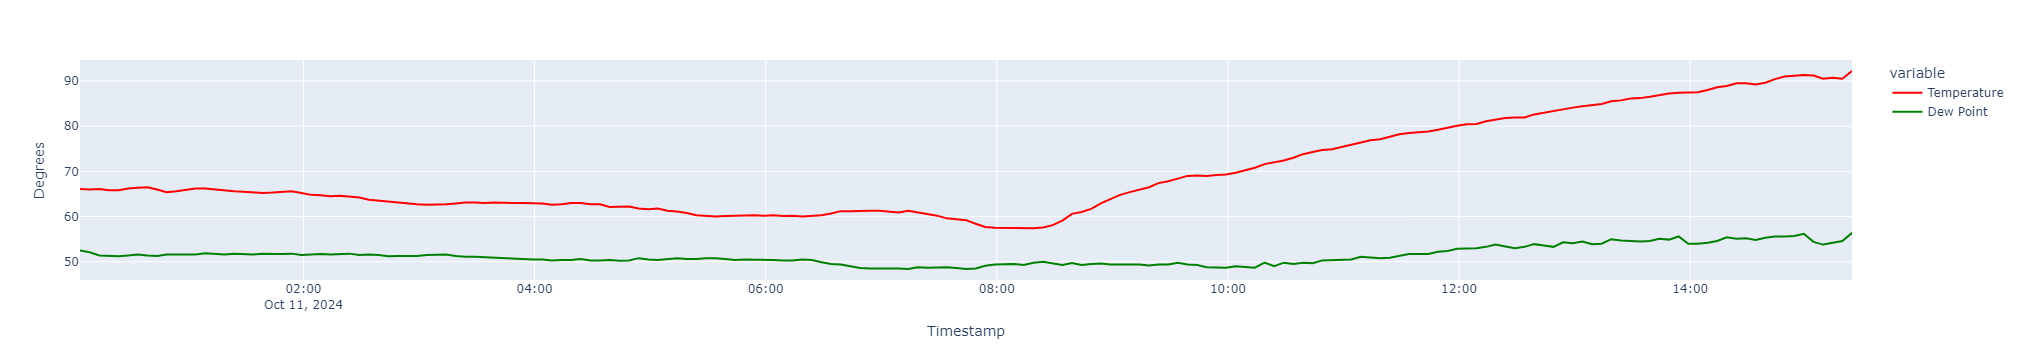

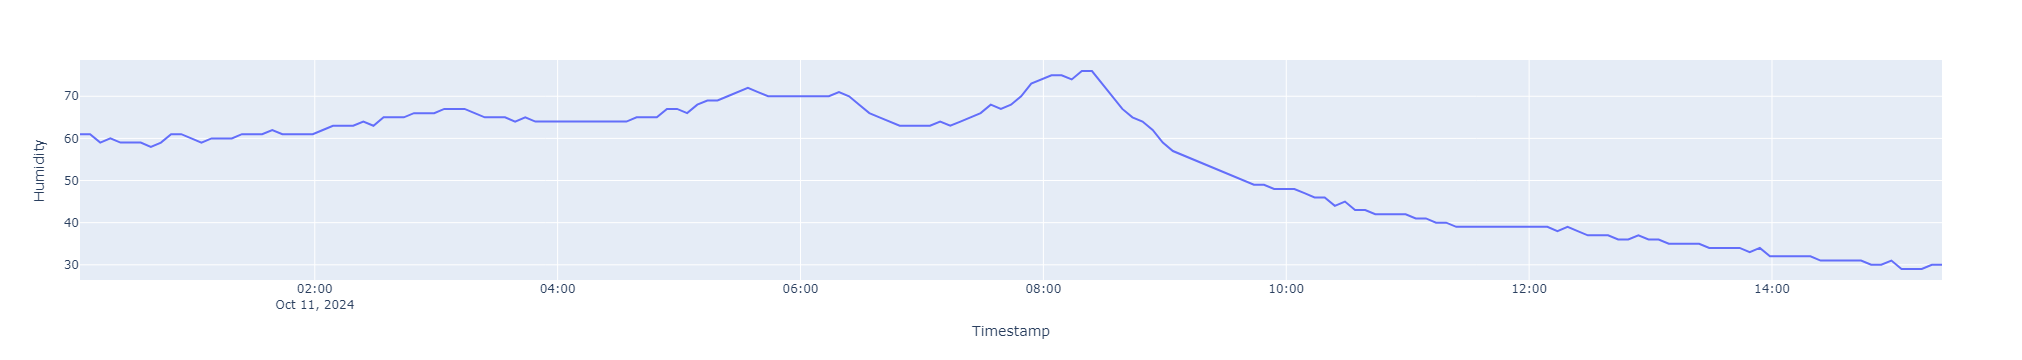

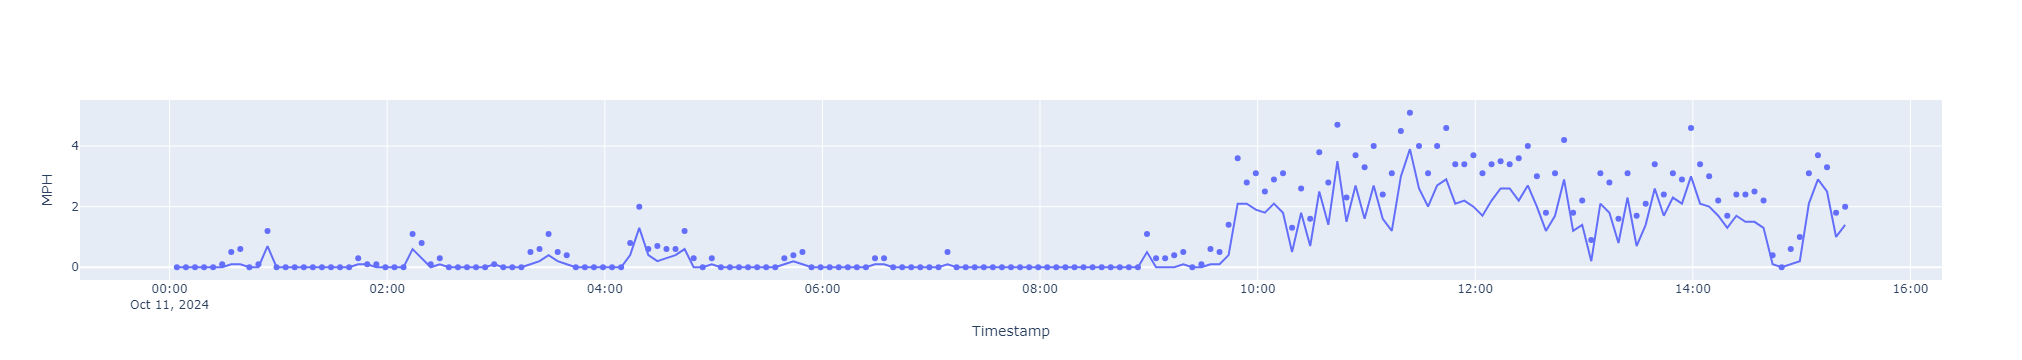

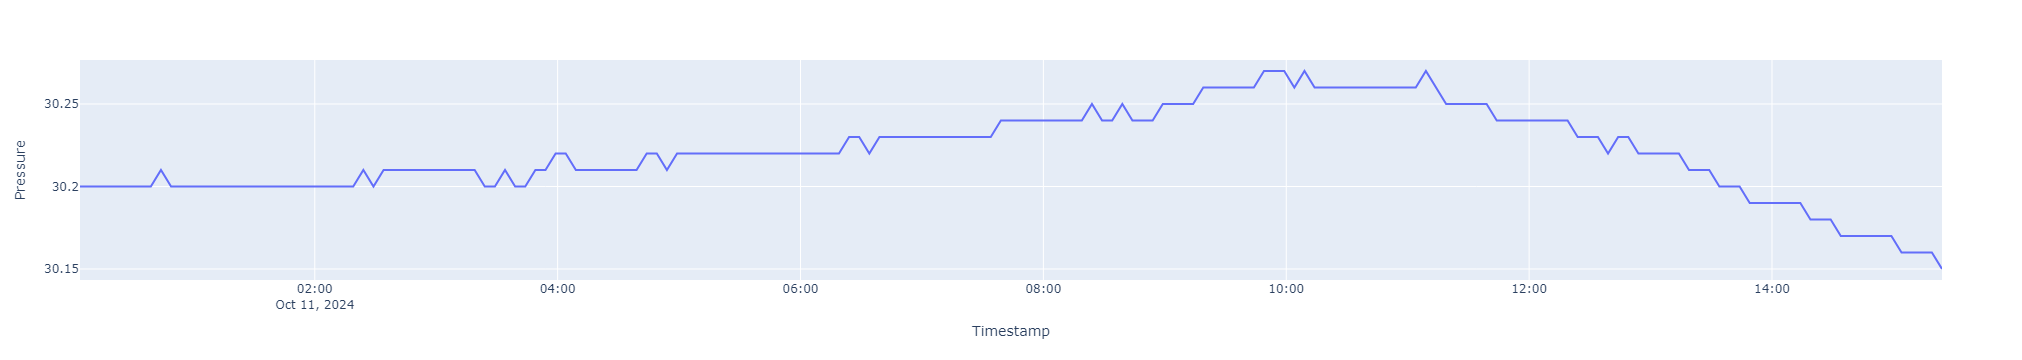

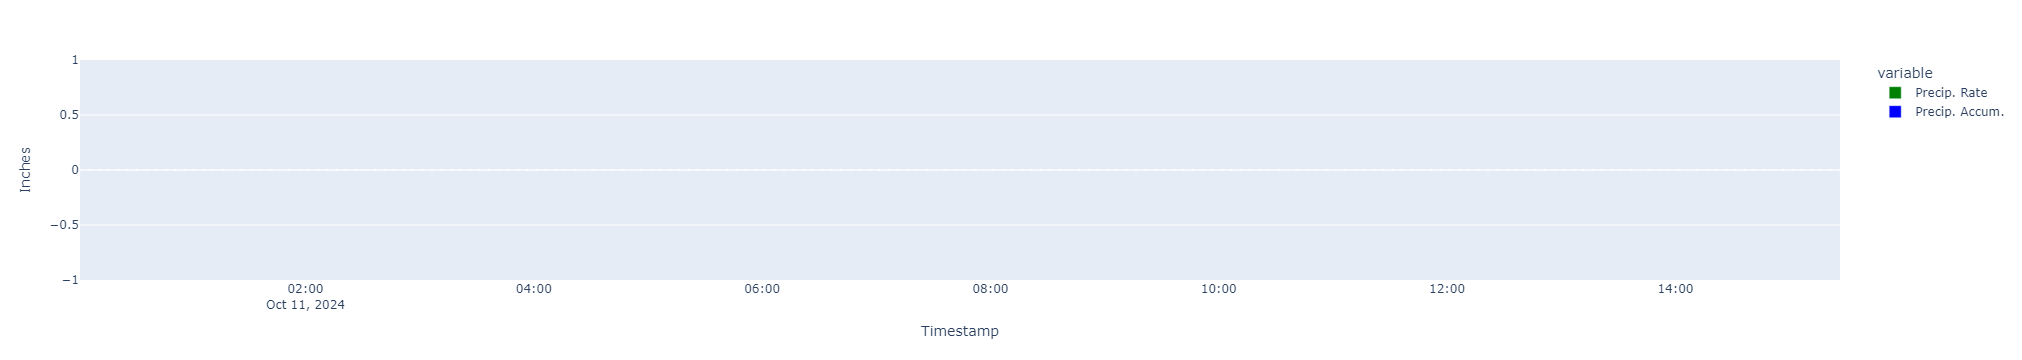

In [39]:
import plotly.express as px

df_temperature_dewpoint = df[['Timestamp', 'Temperature', 'Dew Point']]
df_humidity = df[['Timestamp', 'Humidity']]
df_wind = df[['Timestamp', 'Wind Speed', 'Wind Gust']]
df_pressure = df[['Timestamp', 'Pressure']]
df_rain = df[['Timestamp', 'Precip. Rate', 'Precip. Accum.']]


temp_dewpoint_graph = px.line(
    df_temperature_dewpoint,
    x='Timestamp',
    y=['Temperature', 'Dew Point'],
    labels={'value': 'Degrees'},
    color_discrete_map={
        'Temperature': 'red',
        'Dew Point': 'green'
    }
)

humidity_graph = px.line(
    df_humidity,
    x='Timestamp',
    y='Humidity',
    labels={'value': 'Humidity'},
    color_discrete_map={
        'Humidity': 'red'
    }
)

wind_speed_graph = px.line(
    df_wind,
    x='Timestamp',
    y='Wind Speed',
    labels={'value': 'MPH'},
    color_discrete_map = {
        'Wind Speed': 'blue'
    }
)

wind_gust_graph = px.scatter(
    df_wind,
    x='Timestamp',
    y='Wind Gust',
    labels={'value': 'MPH'},
    color_discrete_map = {
        'Wind Gust': 'orange'
    }
)

pressure_graph = px.line(
    df_pressure,
    x='Timestamp',
    y='Pressure',
    labels={'value': 'Inches'},
    color_discrete_map = {
        'Pressure': 'Black'
    }
)

rain_graph = px.bar(
    df_rain,
    x='Timestamp',
    y=['Precip. Rate', 'Precip. Accum.'],
    labels={'value': 'Inches'},
    color_discrete_map = {
        'Precip. Rate': 'green',
        'Precip. Accum.': 'blue'
    }
)

temp_dewpoint_graph.show()
humidity_graph.show()
wind_graph = go.Figure(data=wind_speed_graph.data + wind_gust_graph.data)
wind_graph.update_layout(xaxis_title='Timestamp', yaxis_title='MPH')
wind_graph.show()
pressure_graph.show()
rain_graph.update_layout(barmode='group')
rain_graph.show()